## Building makemore Part 3: Activations & Gradients, BatchNorm
#### https://www.youtube.com/watch?v=P6sfmUTpUmc

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open("data/names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(chars,1)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3
X, y = [], []

random.seed(42)
random.shuffle(words)

for name in words:
    window = [0] * block_size
    for n in name + ".":
        n = stoi[n]
        X.append(window)
        y.append(n)
        window = window[1:] + [n]

X = torch.tensor(X)
y = torch.tensor(y)

print(X.shape)
print(y.shape)

t = int(0.8*len(X))
d = int(0.9*len(X))
X_train, y_train = X[:t], y[:t]
X_val, y_val = X[t:d], y[t:d]
X_test, y_test = X[d:], y[d:]

torch.Size([228146, 3])
torch.Size([228146])


In [5]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

182516 182516
22815 22815
22815 22815


In [6]:
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g)
b1 = torch.randn(h_size, generator=g)
W2 = torch.randn((h_size,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
for p in parameters:
    p.requires_grad = True

In [48]:
max_step = 200000
batch_size = 32
lr = 0.1

for i in range(max_step):

    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    
    # Forward pass
    emb = C[X_train[ix]]
    hpreact = (emb.view(-1,block_size * v_size) @ W1) + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Batch Normalization
    h = torch.tanh(hpreact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y_train[ix])
    
    # Backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stat
    if i % 10000 == 0:
        print(f'{i:7d}/{max_step:7d}: {loss.item():.4f}')

    break

      0/ 200000: 3.2467


In [46]:
@torch.no_grad()
def check_loss(batch:str):
    batches = {"train":(X_train,y_train),
               "val":(X_val,y_val),
               "test":(X_test, y_test)}
    X = batches[batch][0]
    y = batches[batch][1]
    emb = C[X]
    hpreact = (emb.view(-1,block_size * v_size) @ W1) + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)
    
    print(f"{batch} loss: {loss}")

In [47]:
check_loss("train")
check_loss("val")

train loss: 3.278233051300049
val loss: 3.276777505874634


- Initialization is very important in DL network
- Ideal situation is in a untuned network the logits output must be uniform, i.e, the initial output probs are equal for all labels
- Set bias to zeros
- Another problem with uisng tanh with randomly initialized W results in logits that a simply too large and this causes the output of tanh to be 1 or -1 and the derivative of tanh with 1 or -1 is zero, therefore no gradients passes through when backprop is done
- That's why ensure that 

In [18]:
# Tackling high loss during the beginning of training due to bad initilization
# Initial train loss: 2.122 and val loss: 2.158 when initilization is bad, loss in beginning 21.60

In [19]:
# By initilizing the final layer bias to 0 and multiplying final layer W values with 0.01
# This is done to fix the softmax being confidently wrong
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g)
b1 = torch.randn(h_size, generator=g)
W2 = torch.randn((h_size,27), generator=g) * 0.1
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
# Initial train loss: 2.071 and val loss: 2.132 when initilization is bad, loss in beginning 3.9845

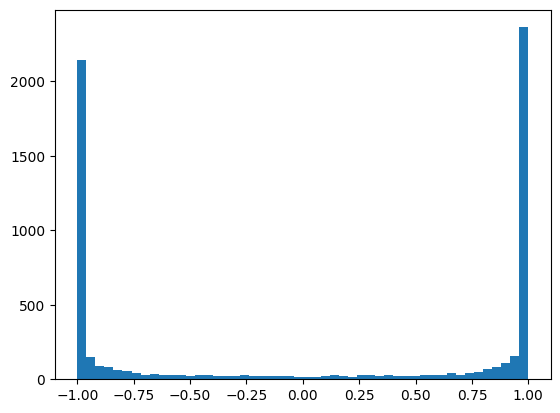

In [20]:
# Another problem with bad initilization is outputs of hiddens states being saturated (1 or -1 coming out of tanh)
plt.hist(h.view(-1).tolist(), 50);

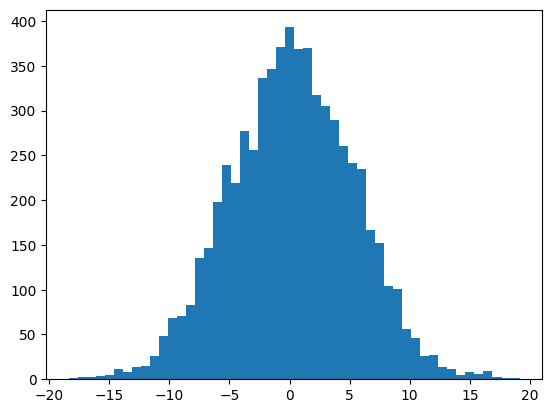

In [21]:
# Extreme values beyond -1.5 and 1.5 tends to be squashed to -1 nd 1 when passed thorugh tanh and this leads to dead neurons buring backprop
plt.hist(hpreact.view(-1).tolist(), 50);

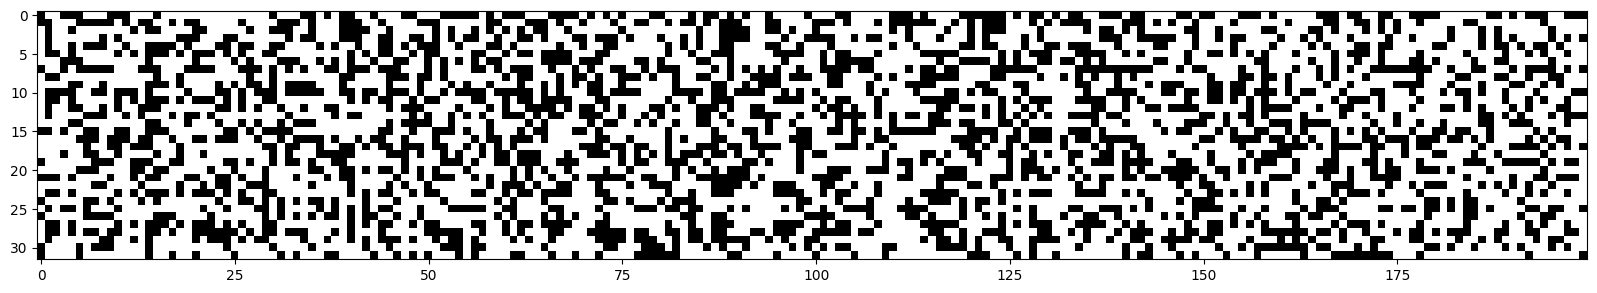

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray")
# If a whole column is white that means a neuron is dead (this neuron is saturated for all examples in mini batch)

In [41]:
# Further reduce saturation by fixing tanh layer
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g) * 0.2
b1 = torch.randn(h_size, generator=g) * 0.01
W2 = torch.randn((h_size,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
# Initial train loss: 2.0368 and val loss: 2.1030 when initilization is bad, loss in beginning 3.3275

tensor(-0.0115) tensor(1.0087)
tensor(0.0015) tensor(1.0348)


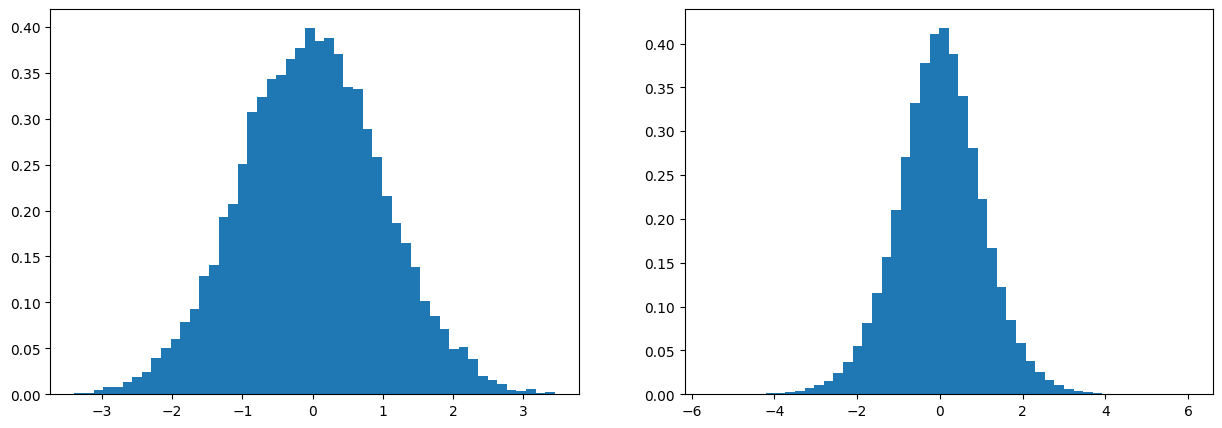

In [24]:
# It is observed that on doing matrix multiplication the variance of the values increases, this leads to exploding logits
# This can be reduced by dividing the W matrix with sqrt(n_in) where n_in represents the zeroth (row) dimension of W
# This method is called kaiming initilization
x = torch.randn(1000, 10)
W = torch.randn(10, 200) / (10**0.5)
y = x @ W
print(x.mean(), x.std())
print(y.mean(), y.std())
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax.flat[0].hist(x.view(-1).tolist(), 50, density=True); # Density param set to True converts y axis to probability density axis
ax.flat[1].hist(y.view(-1).tolist(), 50, density=True);

In [25]:
# Modern innovation on residual connectins, normalization layer, optimizers like adam-rmsprop makes not tuning initilization less forgiving

In [26]:
# Using kaiming initilization
v_size = 10 
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g) * (5/3)/((block_size * v_size)**0.5)
b1 = torch.randn(h_size, generator=g) * 0.01
W2 = torch.randn((h_size,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
# Initial train loss: 2.0380 and val loss: 2.1060 when initilization is bad, loss in beginning 3.3104

In [27]:
hpreact.shape

torch.Size([32, 200])

In [28]:
hpreact.mean(0).shape

torch.Size([200])

In [29]:
# Batch Normlization helps achieve convergence faster
# Why is batch norm done across each dimensions of output???
hpreact.shape

torch.Size([32, 200])

In [40]:
# Introducing natch normalization scale and shift vector
v_size = 10
h_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,v_size), generator=g)
W1 = torch.randn((block_size * v_size, h_size), generator=g) * 0.2
b1 = torch.randn(h_size, generator=g) * 0.01
W2 = torch.randn((h_size,27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

bngain = torch.ones((1, h_size))
bnbias = torch.zeros((1, h_size))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# Initial train loss: 2.0368 and val loss: 2.1030 when initilization is bad, loss in beginning 3.3275